In [1]:
from __future__ import division
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import brown
from nltk import bigrams, ngrams, trigrams 
from nltk.probability import FreqDist as FreqDist  
from numpy.polynomial.polynomial import polyfit
from collections import Counter
from string import digits
from scipy import stats
import operator
from collections import OrderedDict

In [2]:
def get_sentences(num_sentences):
    sentences= brown.sents()[:num_sentences]
    ret=[]
    for sentence in sentences:
        ret.append(' '.join(sentence))
    return ret

In [3]:
def preprocess_sents(sentences):
    sentences = [sentence.lower() for sentence in sentences]
    remove_digits = str.maketrans('', '', digits)
    sentences = [sentence.translate(remove_digits)  for sentence in sentences]
    sentences=[re.sub('\W+',' ', sentence) for sentence in sentences]
    return sentences

In [4]:
def plot(x,y,Title=''):
    x=np.asarray(x)
    y=np.asarray(y)
    print('Slope of best-fit line: ',np.polyfit(x,y,1)[0],', Intercept: ',np.polyfit(x,y,1)[1])
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'r', label='fitted line')
    plt.scatter(x,y,label='original data')
    plt.title(Title)
    plt.legend()
    plt.show()

In [5]:
def unigram_LM(sents):
    unigrams=[]
    for elem in sents:
        unigrams.extend(elem.split())

    unigram_counts=Counter(unigrams)
    unique_unigrams=set(unigrams)
    unigram_total=len(unigrams)
    unigram_freq=dict()
    for word in unigram_counts:
        unigram_freq[word]=unigram_counts[word]/unigram_total

    return unigram_counts,unigram_freq,unigram_total

In [6]:
def bigram_model(sentences,k=0,unique_bigrams_num=0):
    model={}
    for sent in sentences:
         for w1,w2 in ngrams(sent.split(),2, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            if w1 not in model:
                model[w1]={}
            if w2 not in model[w1]:
                model[w1][w2]=0
            model[w1][w2]+=1
    for w1 in model:
        tot_count=float(sum(model[w1].values()))
        for w2 in model[w1]:
            model[w1][w2]+=k
            model[w1][w2]/=(tot_count+k*unique_bigrams_num)
     
    return model



In [7]:
def trigram_model(sentences=0,k=0,unique_trigrams_num=0):
    model={}
    for sent in sentences:
         for w1,w2,w3 in ngrams(sent.split(),3, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            if (w1,w2) not in model:
                model[(w1,w2)]={}
            if w3 not in model[(w1,w2)]:
                model[(w1,w2)][w3]=0
            model[(w1,w2)][w3]+=1
    for (w1,w2) in model:
        tot_count=float(sum(model[(w1,w2)].values()))
        for w3 in model[(w1,w2)]:
            model[(w1,w2)][w3]+=k
            model[(w1,w2)][w3]/=(tot_count+k*unique_trigrams_num)
     
    return model


In [8]:
def get_test_sentences(filename='test_examples.txt'):
    sents=list()
    with open(filename,'r') as f:
        for line in f:
            sents.append(line)
        f.close()
    return preprocess_sents(sents)

In [9]:
def laplacian_unigram_model(w1,unigram_counts,k,N):
    return np.log( ( (k+unigram_counts.get(w1,0))/(k*V+N) )  )
def laplacian_bigram_model(w1,w2,bigram_counts,unigram_counts,k,V):
    return np.log( ( (k+bigram_counts.get((w1,w2),0))/(k*V+unigram_counts.get(w1,0)) )  )

def laplacian_trigram_model(w1,w2,w3,k):
    return np.log( ( (k+trigram_counts.get((w1,w2,w3),0))/(k*V+bigram_counts.get((w1,w2),0)) )  )

### Getting the sentences from the Brown corpus

In [10]:
sents=get_sentences(40000)            # Get 40k sentences from the Brown corpus as mentioned in assignment
sents=preprocess_sents(sents)

In [11]:
for sent in sents[:10]:
    print(sent)

the fulton county grand jury said friday an investigation of atlanta s recent primary election produced no evidence that any irregularities took place 
the jury further said in term end presentments that the city executive committee which had over all charge of the election deserves the praise and thanks of the city of atlanta for the manner in which the election was conducted 
the september october term jury had been charged by fulton superior court judge durwood pye to investigate reports of possible irregularities in the hard fought primary which was won by mayor nominate ivan allen jr 
 only a relative handful of such reports was received the jury said considering the widespread interest in the election the number of voters and the size of this city 
the jury said it did find that many of georgia s registration and election laws are outmoded or inadequate and often ambiguous 
it recommended that fulton legislators act to have these laws studied and revised to the end of modernizing

## Creating the Language Models

In [12]:
unigram_counts,unigram_freq,unigram_total=unigram_LM(sents)  # create the n-gram models without smoothing
bigram_LM= bigram_model(sents)
trigram_LM= trigram_model(sents)

## Verifying Zipf's Law

Slope of best-fit line:  -1.166736034411795 , Intercept:  11.838045961079029


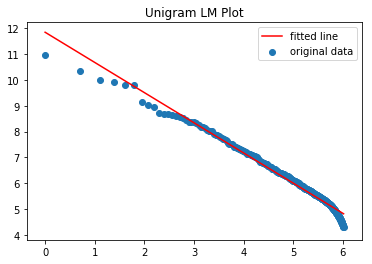

In [13]:
lis=[y[1] for y in unigram_counts.most_common()]
lis=np.flip(np.unique(lis),0)
lis=lis[:(int)(0.85*len(lis))]
x=[np.log(i+1) for i in range(len(lis))]
y=np.asarray(list(np.log(y) for y in lis))
plot(x,y,'Unigram LM Plot')
sorted_unigram_counts=sorted(unigram_counts.items(), key=operator.itemgetter(1),reverse=True)

In [14]:
bigram_counts={}
for sent in sents:
    for w in ngrams(sent.split(),2, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if(w not in bigram_counts):
            bigram_counts[w]=1
        else:
            bigram_counts[w]+=1


sorted_bigram_counts=sorted(bigram_counts.items(), key=operator.itemgetter(1),reverse=True)

Slope of best-fit line:  -0.9606201477375457 , Intercept:  9.790213310220958


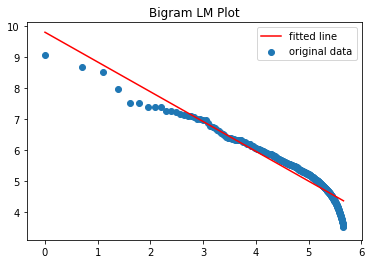

In [15]:
len_bigrams=len(sorted_bigram_counts)
lis=[y[1] for y in sorted_bigram_counts]
lis=np.flip(np.unique(lis),0)
lis=lis[:(int)(0.9*len(lis))]
x=[np.log(i+1) for i in range(len(lis))]
y=np.asarray(list(np.log(y) for y in lis))
plot(x,y,'Bigram LM Plot')

In [16]:
trigram_counts={}
for sent in sents:
    for w in ngrams(sent.split(),3, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if(w not in trigram_counts):
            trigram_counts[w]=1
        else:
            trigram_counts[w]+=1



sorted_trigram_counts=sorted(trigram_counts.items(), key=operator.itemgetter(1),reverse=True)

Slope of best-fit line:  -1.0414259733873539 , Intercept:  9.008746176389943


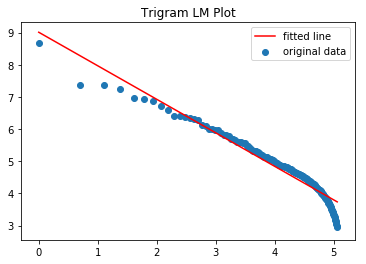

In [17]:
lis=[y[1] for y in sorted_trigram_counts]
lis=np.flip(np.unique(lis),0)
lis=lis[:(int)(0.9*len(lis))]
x=[np.log(i+1) for i in range(len(lis))]
y=np.asarray(list(np.log(y) for y in lis))
plot(x,y,'Trigram LM Plot')

In [18]:
sorted_unigram_counts[:11]

[('the', 56474),
 ('of', 31329),
 ('and', 22154),
 ('to', 20413),
 ('a', 17918),
 ('in', 17766),
 ('is', 9474),
 ('that', 8306),
 ('for', 7797),
 ('it', 6198),
 ('was', 5967)]

In [19]:
tmp=[p for p in sorted_bigram_counts if p[0][0]!='<s>' and p[0][1]!='<s>']
tmp[:10]

[(('of', 'the'), 8512),
 (('in', 'the'), 4986),
 (('to', 'the'), 2820),
 (('and', 'the'), 1848),
 (('on', 'the'), 1829),
 (('for', 'the'), 1592),
 (('it', 'is'), 1390),
 (('to', 'be'), 1377),
 (('with', 'the'), 1261),
 (('that', 'the'), 1243)]

In [20]:
tmp=[p for p in sorted_trigram_counts if p[0][0]!='<s>' and  p[0][1]!='</s>' and  p[0][2]!='</s>' ]
tmp[:10]

[(('one', 'of', 'the'), 337),
 (('the', 'united', 'states'), 336),
 (('as', 'well', 'as'), 225),
 (('some', 'of', 'the'), 156),
 (('the', 'fact', 'that'), 154),
 (('part', 'of', 'the'), 131),
 (('of', 'the', 'united'), 127),
 (('the', 'u', 's'), 126),
 (('it', 'is', 'not'), 126),
 (('a', 'number', 'of'), 118)]

## Testing (without smoothing)

In [21]:
print('Please input the name of the test file')
filename=input()                        # enter the name of the test file
test_sents=get_test_sentences(filename)  # Gettting the test sentences

Please input the name of the test file
test_examples.txt


In [22]:
test_unigram_arr=[]                      # Log-likelihood and Perplexity for Unigram Model without smoothing
print('Unigram test Log-likelihood without smoothing: ')
print()
for sent in test_sents:
    try:
        p_val=np.sum([np.log(unigram_freq[word]) for word in sent.split()])
    except Exception as e:
        p_val=-np.inf
    test_unigram_arr.append(p_val)
    N=len(sent.split())+1                    # +1 to account for </s> token as suggested by Jurafsky et. al
    if(p_val!=(-np.inf)):
        prob=np.exp(p_val)
        perplexity=1/(np.power(prob,(1.0/N)))
    else:
        perplexity=np.inf
    print('The sequence \"'+sent+' \" has unigram log likelihood of '+ str(round(p_val,2))+' and perplexity '+str(round(perplexity,2)))
    test_unigram_arr.append(p_val)

Unigram test Log-likelihood without smoothing: 

The sequence "he lived a good life  " has unigram log likelihood of -32.62 and perplexity 229.54
The sequence "the man was happy  " has unigram log likelihood of -23.9 and perplexity 119.04
The sequence "the person was good  " has unigram log likelihood of -23.33 and perplexity 106.2
The sequence "the girl was sad  " has unigram log likelihood of -27.22 and perplexity 231.47
The sequence "he won the war " has unigram log likelihood of -24.11 and perplexity 124.14


In [23]:
test_bigram_arr=[]
print('Bigram Model without smoothing')
for sent in test_sents:
    p_val=0
    for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if w1 in bigram_LM:
            try:
                p_val+=np.log(bigram_LM[w1][w2])
            except Exception as e:
                p_val=-np.inf
                break
        else:
            p_val=-np.inf
            break
    N=len(sent.split())+1                    # +1 to account for </s> token as suggested by Jurafsky et. al.
    if(p_val!=(-np.inf)):
        prob=np.exp(p_val)
        perplexity=1/(np.power(prob,(1.0/N)))
    else:
        perplexity=np.inf
    print('The sequence \"'+ sent +'\" has bigram log likelihood of '+ str(round(p_val,2))+' and perplexity '+str(round(perplexity,2)))
    test_bigram_arr.append(p_val)

Bigram Model without smoothing
The sequence "he lived a good life " has bigram log likelihood of -26.89 and perplexity 88.33
The sequence "the man was happy " has bigram log likelihood of -22.06 and perplexity 82.46
The sequence "the person was good " has bigram log likelihood of -24.84 and perplexity 143.74
The sequence "the girl was sad " has bigram log likelihood of -inf and perplexity inf
The sequence "he won the war" has bigram log likelihood of -20.08 and perplexity 55.47


In [24]:
test_trigram_arr=[]
print('Trigram model without smoothing: ')
for sent in test_sents:
    p_val=0
    for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        try:
            p_val+=np.log(trigram_LM[(w1,w2)][w3])
        except Exception as e:
            p_val=-np.inf
            break
    N=len(sent.split())+1                    # +1 to account for </s> token as suggested by Jurafsky et. al.
    if(p_val!=(-np.inf)):
        prob=np.exp(p_val)
        perplexity=1/(np.power(prob,(1.0/N)))
    else:
        perplexity=np.inf
    print('The sequence \"'+ sent +'\" has trigram log likelihood of '+str(round(p_val,2))+' and perplexity '+str(round(perplexity,2)))    
    test_trigram_arr.append(p_val)

Trigram model without smoothing: 
The sequence "he lived a good life " has trigram log likelihood of -inf and perplexity inf
The sequence "the man was happy " has trigram log likelihood of -inf and perplexity inf
The sequence "the person was good " has trigram log likelihood of -inf and perplexity inf
The sequence "the girl was sad " has trigram log likelihood of -inf and perplexity inf
The sequence "he won the war" has trigram log likelihood of -16.52 and perplexity 27.22


## Laplace/ Additive Smoothing

In [25]:
unigram_counts['<s>']=len(sents)
k_list=[pow(10,i) for i in range(-4,1)]
V=len(unigram_counts.values())

In [26]:
test_uniigram_arr=[]
for k in k_list:
    print('Unigram test log likelihood with Laplacian/ Additive Smoothing with k as',k,': \n')
    for sent in test_sents:
        p_val=0
        for w1 in sent.split():
            p_val+=laplacian_unigram_model(w1,unigram_counts,k,unigram_total)
        N=len(sent.split())+1                    # +1 to account for </s> token as suggested by Jurafsky et. al.
        if(p_val!=(-np.inf)):
            prob=np.exp(p_val)
            perplexity=1/(np.power(prob,(1.0/N)))
        else:
            perplexity=np.inf
        print('The sequence \"'+ sent +'\" has unigram log likelihood of '+ str(round(p_val,2))+' and perplexity '+str(round(perplexity,2)))
        test_unigram_arr.append(p_val)
    print("\n")
    

Unigram test log likelihood with Laplacian/ Additive Smoothing with k as 0.0001 : 

The sequence "he lived a good life " has unigram log likelihood of -32.62 and perplexity 229.54
The sequence "the man was happy " has unigram log likelihood of -23.9 and perplexity 119.04
The sequence "the person was good " has unigram log likelihood of -23.33 and perplexity 106.2
The sequence "the girl was sad " has unigram log likelihood of -27.22 and perplexity 231.47
The sequence "he won the war" has unigram log likelihood of -24.11 and perplexity 124.14


Unigram test log likelihood with Laplacian/ Additive Smoothing with k as 0.001 : 

The sequence "he lived a good life " has unigram log likelihood of -32.62 and perplexity 229.54
The sequence "the man was happy " has unigram log likelihood of -23.9 and perplexity 119.04
The sequence "the person was good " has unigram log likelihood of -23.33 and perplexity 106.21
The sequence "the girl was sad " has unigram log likelihood of -27.22 and perplexity 

In [27]:
test_bigram_arr=[]
for k in k_list:

    print('Bigram test log likelihood with Laplacian/ Additive Smoothing with k as',k,': ')
    for sent in test_sents:
        p_val=0
        for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=laplacian_bigram_model(w1,w2,bigram_counts,unigram_counts,k,V)
        N=len(sent.split())+1                    # +1 to account for </s> token as suggested by Jurafsky et. al.
        if(p_val!=(-np.inf)):
            prob=np.exp(p_val)
            perplexity=1/(np.power(prob,(1.0/N)))
        else:
            perplexity=np.inf
        print('The sequence \"'+ sent +'\" has bigram log likelihood of '+ str(round(p_val,2))+' and perplexity '+str(round(perplexity,2)))
        test_bigram_arr.append(p_val)
    print("\n")

Bigram test log likelihood with Laplacian/ Additive Smoothing with k as 0.0001 : 
The sequence "he lived a good life " has bigram log likelihood of -26.96 and perplexity 89.36
The sequence "the man was happy " has bigram log likelihood of -22.13 and perplexity 83.56
The sequence "the person was good " has bigram log likelihood of -24.87 and perplexity 144.68
The sequence "the girl was sad " has bigram log likelihood of -34.43 and perplexity 978.81
The sequence "he won the war" has bigram log likelihood of -20.12 and perplexity 55.97


Bigram test log likelihood with Laplacian/ Additive Smoothing with k as 0.001 : 
The sequence "he lived a good life " has bigram log likelihood of -27.47 and perplexity 97.38
The sequence "the man was happy " has bigram log likelihood of -22.6 and perplexity 91.87
The sequence "the person was good " has bigram log likelihood of -25.14 and perplexity 152.63
The sequence "the girl was sad " has bigram log likelihood of -33.36 and perplexity 790.43
The seque

In [28]:
for k in k_list:
    test_trigram_arr=[]
    print('Trigram test log likelihoods with Laplacian/ Additive Smoothing with k as',k,': \n')
    for sent in test_sents:
        p_val=0
        for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=laplacian_trigram_model(w1,w2,w3,k)
        N=len(sent.split())+1                    # +1 to account for </s> token as suggested by Jurafsky et. al.
        if(p_val!=(-np.inf)):
            prob=np.exp(p_val)
            perplexity=1/(np.power(prob,(1.0/N)))
        else:
            perplexity=np.inf
        print('The sequence \"'+ sent +'\" has trigram log likelihood of '+ str(round(p_val,2))+' and perplexity '+str(round(perplexity,2)))

        test_trigram_arr.append(p_val)
    print("\n")

Trigram test log likelihoods with Laplacian/ Additive Smoothing with k as 0.0001 : 

The sequence "he lived a good life " has trigram log likelihood of -38.41 and perplexity 602.76
The sequence "the man was happy " has trigram log likelihood of -25.16 and perplexity 153.19
The sequence "the person was good " has trigram log likelihood of -25.45 and perplexity 162.36
The sequence "the girl was sad " has trigram log likelihood of -26.66 and perplexity 207.05
The sequence "he won the war" has trigram log likelihood of -7.92 and perplexity 4.88


Trigram test log likelihoods with Laplacian/ Additive Smoothing with k as 0.001 : 

The sequence "he lived a good life " has trigram log likelihood of -39.9 and perplexity 772.27
The sequence "the man was happy " has trigram log likelihood of -27.39 and perplexity 239.14
The sequence "the person was good " has trigram log likelihood of -28.34 and perplexity 289.62
The sequence "the girl was sad " has trigram log likelihood of -31.56 and perplexity

# Good Turing Smoothing

In [29]:
def  build_N_counts_bigram(language_model):
    global N_counts_bigram
    global N_bigram
    for key,value in language_model.items():
        if value not in N_counts_bigram:
            N_counts_bigram[value]=1
        else:
            N_counts_bigram[value]+=1
    N_counts_bigram[0]=V*V-(len(language_model.keys()))            # Bigrams not seen

    for key,value in N_counts_bigram.items():                      # Total number of bigrams
        N_bigram+=(key*value)
        
def  build_N_counts_trigram(language_model):
    global N_counts_trigram
    global N_trigram
    for key,value in language_model.items():
        if value not in N_counts_trigram:
            N_counts_trigram[value]=1
        else:
            N_counts_trigram[value]+=1

    N_counts_trigram[0]=V*V*V-(len(language_model.keys()))          # Trigrams not seen
    N_trigram=0
    for key,value in N_counts_trigram.items():                      # Total number of trigrams
        N_trigram+=(key*value)
        
def GoodTuring_bigram(k):       
    GT_bigram=dict()
    r_list=[r for r in bigram_counts.values()]
    r_list=list(set(r_list))
    for r in r_list:
        GT_bigram[r]=P_GT_bigram_r(r,k)
    GT_bigram[0]=P_GT_bigram_r(0,k)
    prob_norm_sum=sum(GT_bigram.values())
    for key in GT_bigram.keys():
        GT_bigram[key]/=prob_norm_sum
    return GT_bigram

def P_GT_bigram(w1,w2):
    r=bigram_counts.get((w1,w2),0)
    return GT_bigram[r]
def P_GT_bigram_r(r,k):
    if(r>k):
        return (r/N_bigram)
    else:
        numerator_first=(r+1)*(N_counts_bigram[r+1]/N_counts_bigram[r])
        r_star=numerator_first
        return (r_star/N_bigram)   
    
def GoodTuring_trigram(k):       
    GT_trigram=dict()
    r_list=[r for r in trigram_counts.values()]
    r_list=list(set(r_list))
    for r in r_list:
        GT_trigram[r]=P_GT_trigram_r(r,k)
    GT_trigram[0]=P_GT_trigram_r(0,k)
    prob_norm_sum=sum(GT_trigram.values())
    for key in GT_trigram.keys():
        GT_trigram[key]/=prob_norm_sum
    return GT_trigram

def P_GT_trigram(w1,w2,w3):
    r=trigram_counts.get((w1,w2,w3),0)
    return GT_trigram[r]    

def P_GT_trigram_r(r,k):
    if(r>k):
        return (r/N_trigram)
    else:
        numerator_first=(r+1)*(N_counts_trigram[r+1]/N_counts_trigram[r])
        r_star=numerator_first
        return (r_star/N_trigram)   
    

In [30]:
k=5
N_counts_bigram=dict()
N_bigram=0
build_N_counts_bigram(bigram_counts)
GT_bigram=GoodTuring_bigram(k)
N_counts_trigram=dict()
N_trigram=0

print('Bigram model with Good Turing Smoothing')
unigram_freq['<s>']=unigram_counts['<s>']/V
test_bigram_arr=[]
k=10
for sent in test_sents:
    p_val=0
    for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        try:
            p_val+=np.log(P_GT_bigram(w1,w2)/unigram_freq.get(w1,0))
        except Exception as e:
            p_val=-np.inf
            break
    N=len(sent.split())+1                    # +1 to account for </s> token as suggested by Jurafsky et. al.
    if(p_val!=(-np.inf)):
        prob=np.exp(p_val)
        perplexity=1/(np.power(prob,(1.0/N)))
    else:
        perplexity=np.inf
    print('The sequence \"'+ sent +'\" has bigram log likelihood of '+str(round(p_val,2))+' and perplexity '+str(round(perplexity,2)))
    test_bigram_arr.append(p_val)

Bigram model with Good Turing Smoothing
The sequence "he lived a good life " has bigram log likelihood of -20.25 and perplexity 29.22
The sequence "the man was happy " has bigram log likelihood of -15.42 and perplexity 21.86
The sequence "the person was good " has bigram log likelihood of -19.3 and perplexity 47.45
The sequence "the girl was sad " has bigram log likelihood of -27.58 and perplexity 248.87
The sequence "he won the war" has bigram log likelihood of -13.07 and perplexity 13.66


In [31]:
build_N_counts_trigram(trigram_counts)
GT_trigram=GoodTuring_trigram(k)

test_trigram_arr=[]
print('Trigram model with Good Turing Smoothing: ')
for sent in test_sents:
    p_val=0
    for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        try:
            if (w1=='<s>' and w2=='<s>'):
                p_val+=np.log(P_GT_trigram(w1,w2,w3)/(unigram_counts['<s>']/N_bigram))
            else:
                p_val+=np.log(P_GT_trigram(w1,w2,w3)/(bigram_counts.get((w1,w2),0)/N_bigram))
        except Exception as e:
            p_val=-np.inf
            break
    N=len(sent.split())+1                    # +1 to account for </s> token as suggested by Jurafsky et. al.
    if(p_val!=(-np.inf)):
        prob=np.exp(p_val)
        perplexity=1/(np.power(prob,(1.0/N)))
    else:
        perplexity=np.inf
    print('The sequence \"'+ sent +'\" has trigram log likelihood of '+ str(round(p_val,2))+' and perplexity '+str(round(perplexity,2)))
    
    test_trigram_arr.append(p_val)

Trigram model with Good Turing Smoothing: 
The sequence "he lived a good life " has trigram log likelihood of -51.85 and perplexity 5665.0
The sequence "the man was happy " has trigram log likelihood of -32.73 and perplexity 697.1
The sequence "the person was good " has trigram log likelihood of -34.15 and perplexity 925.72
The sequence "the girl was sad " has trigram log likelihood of -inf and perplexity inf
The sequence "he won the war" has trigram log likelihood of -2.65 and perplexity 1.7


## Interpolation Models

In [32]:
def interpolation_bigram(w1,w2,Lambda,bigram_counts,unigram_counts):
    num_unigrams=len(unigram_counts.values())
    if (w1 in unigram_counts):
        probability= Lambda*((bigram_counts.get((w1,w2),0))/(unigram_counts.get(w1,0))) +(1-Lambda)*(unigram_counts.get(w2,0)/num_unigrams)
    else:
        print(w1)
        return -np.inf
    if(probability==0):
        return -np.inf
    else:
        return np.log(probability)

In [33]:
print("Interpolation for Bigram Language Model: ")
test_bigram_arr=[]
lambda_list=[0.2, 0.5, 0.8]                    # List of lamda to test on
num_unique_bigrams=len(bigram_counts.values())
for Lambda in lambda_list:

    print('Bigram test log likelihoods with Interpolation with lambda as',Lambda,': ')
    for sent in test_sents:
        p_val=0
        for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=interpolation_bigram(w1,w2,Lambda,bigram_counts,unigram_counts)
        N=len(sent.split())+1                    # +1 to account for </s> token as suggested by Jurafsky et. al.
        if(p_val!=(-np.inf)):
            prob=np.exp(p_val)
            perplexity=1/(np.power(prob,(1.0/N)))
        else:
            perplexity=np.inf
        print('The sequence \"'+ sent +'\" has bigram log likelihood of '+ str(round(p_val,2))+' and perplexity '+str(round(perplexity,2)))
        test_bigram_arr.append(p_val)
    print("\n")

Interpolation for Bigram Language Model: 
Bigram test log likelihoods with Interpolation with lambda as 0.2 : 
The sequence "he lived a good life " has bigram log likelihood of -21.22 and perplexity 34.36
The sequence "the man was happy " has bigram log likelihood of -16.1 and perplexity 25.02
The sequence "the person was good " has bigram log likelihood of -16.22 and perplexity 25.63
The sequence "the girl was sad " has bigram log likelihood of -19.52 and perplexity 49.59
The sequence "he won the war" has bigram log likelihood of -15.81 and perplexity 23.6


Bigram test log likelihoods with Interpolation with lambda as 0.5 : 
The sequence "he lived a good life " has bigram log likelihood of -21.71 and perplexity 37.26
The sequence "the man was happy " has bigram log likelihood of -16.67 and perplexity 28.03
The sequence "the person was good " has bigram log likelihood of -16.99 and perplexity 29.89
The sequence "the girl was sad " has bigram log likelihood of -20.27 and perplexity 57.